<a href="https://colab.research.google.com/github/KrishnaGupta4135/Patota-leafs-disease-classification/blob/main/plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Plant disease/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [ ]:
class_names =dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
len(dataset)*BATCH_SIZE #for just check

2176

In [ ]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 2 2 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1]


In [ ]:
# print first Image / and chanege the tensor to numpy array
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[157. 159. 172.]
  [154. 156. 169.]
  [153. 155. 168.]
  ...
  [184. 186. 198.]
  [183. 185. 197.]
  [183. 185. 197.]]

 [[155. 157. 170.]
  [152. 154. 167.]
  [150. 152. 165.]
  ...
  [184. 186. 198.]
  [185. 187. 199.]
  [187. 189. 201.]]

 [[155. 157. 170.]
  [153. 155. 168.]
  [150. 152. 165.]
  ...
  [184. 186. 198.]
  [187. 189. 201.]
  [190. 192. 204.]]

 ...

 [[118. 115. 124.]
  [118. 115. 124.]
  [113. 110. 119.]
  ...
  [144. 147. 156.]
  [146. 149. 158.]
  [139. 142. 151.]]

 [[117. 114. 123.]
  [116. 113. 122.]
  [106. 103. 112.]
  ...
  [144. 147. 156.]
  [148. 151. 160.]
  [147. 150. 159.]]

 [[128. 125. 134.]
  [122. 119. 128.]
  [103. 100. 109.]
  ...
  [127. 130. 139.]
  [132. 135. 144.]
  [135. 138. 147.]]]


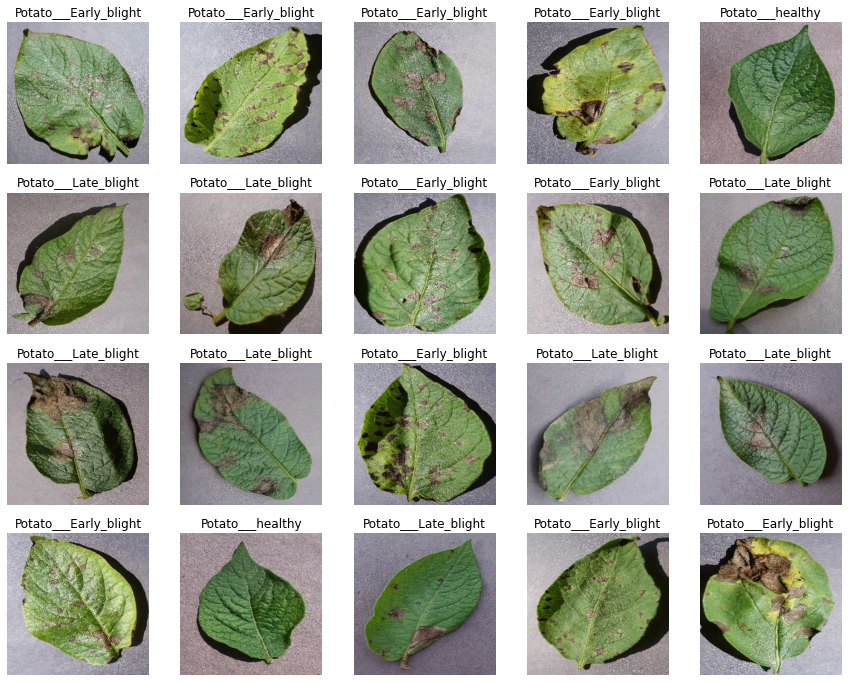

In [ ]:
#visualization of image
plt.figure(figsize=(15,12))
for i in range(20):
    ax=plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Function to Split Dataset


Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle =True,shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed =12)
    
    train_size =int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    ds
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds =get_dataset_partitions_tf(dataset)

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds)

54

Building the Model

Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we lshould normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =3


model= models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size= (3,3), activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

The compile method requires several parameters. The loss parameter is specified to have type 'categorical_crossentropy'. The metrics parameter is set to 'accuracy' and finally we use the adam optimizer for training the network. The output at this stage is shown below

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 360s 301ms/step - loss: 0.8986 - accuracy: 0.4786 - val_loss: 0.8668 - val_accuracy: 0.6458
Epoch 2/10
54/54 [==============================] - 13s 238ms/step - loss: 0.7152 - accuracy: 0.6910 - val_loss: 0.6370 - val_accuracy: 0.7083
Epoch 3/10
54/54 [==============================] - 13s 235ms/step - loss: 0.4832 - accuracy: 0.7865 - val_loss: 0.4098 - val_accuracy: 0.8125
Epoch 4/10
54/54 [==============================] - 13s 242ms/step - loss: 0.3988 - accuracy: 0.8443 - val_loss: 0.2671 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 13s 242ms/step - loss: 0.3038 - accuracy: 0.8872 - val_loss: 0.3417 - val_accuracy: 0.8542
Epoch 6/10
54/54 [==============================] - 13s 235ms/step - loss: 0.2949 - accuracy: 0.8854 - val_loss: 0.2581 - val_accuracy: 0.8906
Epoch 7/10
54/54 [==============================] - 13s 248ms/step - loss: 0.2411 - accuracy: 0.9057 - val_loss: 0.2857 - val_accuracy: 0.890

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 27ms/step - loss: 0.3966 - accuracy: 0.8398


In [ ]:
scores

[0.3966418206691742, 0.83984375]

In [ ]:
history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

10

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8986042141914368,
 0.7152027487754822,
 0.48315441608428955,
 0.39884936809539795,
 0.3037954270839691]

In [ ]:
acc= history.history['accuracy']
val_acc =history.history['val_accuracy']

loss =history.history['loss']
val_loss =history.history['val_loss']

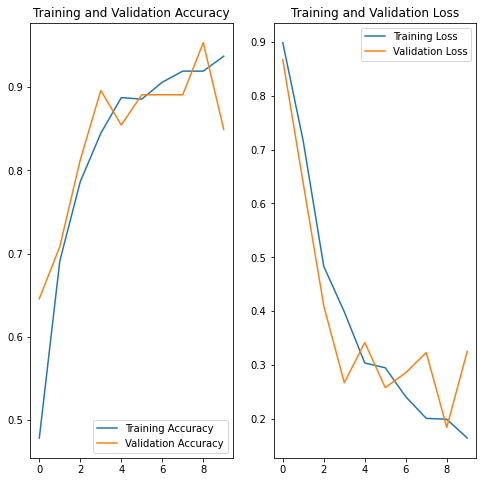

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 147ms/step
predicted label: Potato___Early_blight


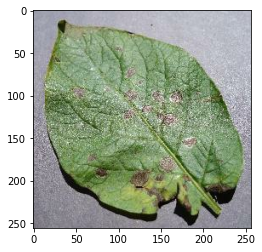

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


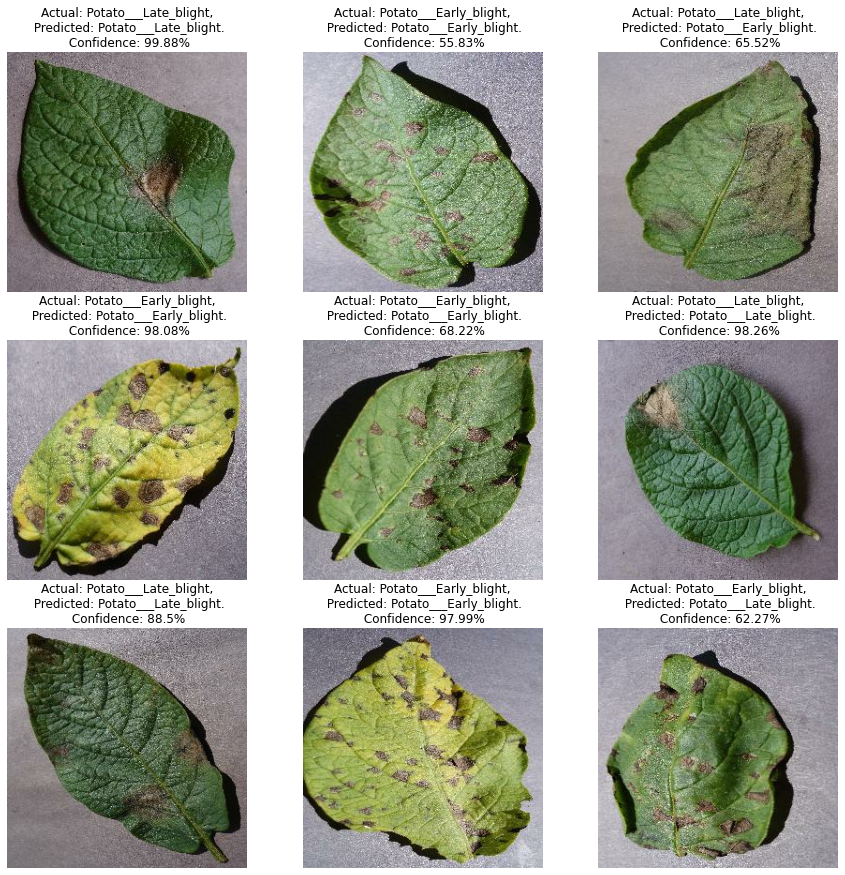

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../content/drive/MyDrive/Plant disease/models") + [0]])+1
model.save(f"../content/drive/MyDrive/Plant disease/models/{model_version}")

In [ ]:
model.save("../potatoes.h5")